# 04. SMOTE & PCA Analysis
In this notebook, we explore alternative techniques for handling class imbalance (SMOTE) and feature extraction (PCA) to see if they offer improvements over our current weighting-based approach.

## 1. Setup & Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, PrecisionRecallDisplay
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette('viridis')

In [2]:
# Load data
df = pd.read_csv('../data/final_modeling_data.csv')

# Basic Preprocessing
target = 'loan_default'
categorical_cols = ['Employment.Type', 'State_ID', 'manufacturer_id', 'branch_id']
categorical_cols = [col for col in categorical_cols if col in df.columns]
df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (Crucial for PCA and SMOTE distance metrics)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. SMOTE (Synthetic Minority Over-sampling Technique)
SMOTE creates synthetic samples rather than just weighting existing ones. This can help the model learn more robust decision boundaries.

In [3]:
print(f"Class balance before SMOTE: {np.bincount(y_train)}")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Class balance after SMOTE: {np.bincount(y_resampled)}")

# Train Logistic Regression on SMOTE data
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_resampled, y_resampled)

y_pred_smote = lr_smote.predict(X_test_scaled)
y_prob_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]

print("SMOTE Logistic Regression Performance:")
print(classification_report(y_test, y_pred_smote))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_smote):.4f}")

Class balance before SMOTE: [146034  40489]
Class balance after SMOTE: [146034 146034]
SMOTE Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.85      0.57      0.68     36509
           1       0.29      0.65      0.40     10122

    accuracy                           0.58     46631
   macro avg       0.57      0.61      0.54     46631
weighted avg       0.73      0.58      0.62     46631

AUC-ROC: 0.6445


> [!NOTE]
> **SMOTE Observation**: SMOTE balances the training set by creating synthetic 'default' cases. While it often improves recall, it can sometimes increase false positives if the synthetic data points are created in regions of feature space occupied by both classes.

## 3. PCA (Principal Component Analysis)
PCA reduces dimensionality by projecting data into components that capture the most variance. We'll see how many components are needed to capture 90% of the variance.

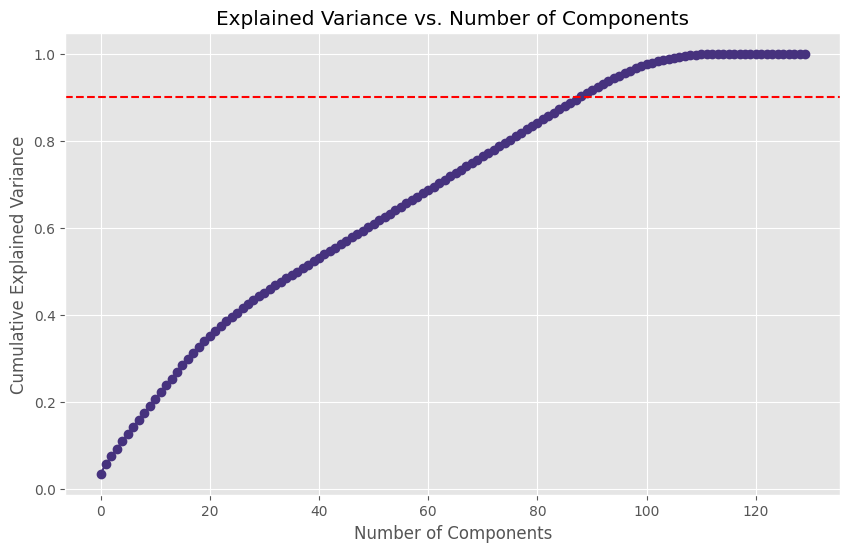

In [4]:
pca = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

> [!NOTE]
> **PCA Scree Plot**: This plot shows how many features are actually needed to represent most of the information in our 100+ encoded features. If the curve flattens quickly, it means we have high multicollinearity.

In [5]:
# Apply PCA - targeting 95% variance
pca_95 = PCA(n_components=0.95)
X_train_pca = pca_95.fit_transform(X_train_scaled)
X_test_pca = pca_95.transform(X_test_scaled)

print(f"Reduced dimensions from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")

# Train on PCA components
lr_pca = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_pca.fit(X_train_pca, y_train)

y_prob_pca = lr_pca.predict_proba(X_test_pca)[:, 1]
print(f"PCA (95% Var) AUC-ROC: {roc_auc_score(y_test, y_prob_pca):.4f}")

Reduced dimensions from 130 to 97
PCA (95% Var) AUC-ROC: 0.6382


> [!IMPORTANT]
> **PCA Trade-off**: By using only the top components, we might lose the specific predictive power of engineered interactions (like 'Triple Threat'), but we gain a simpler feature space with no multicollinearity.

## 4. Evaluation Comparison

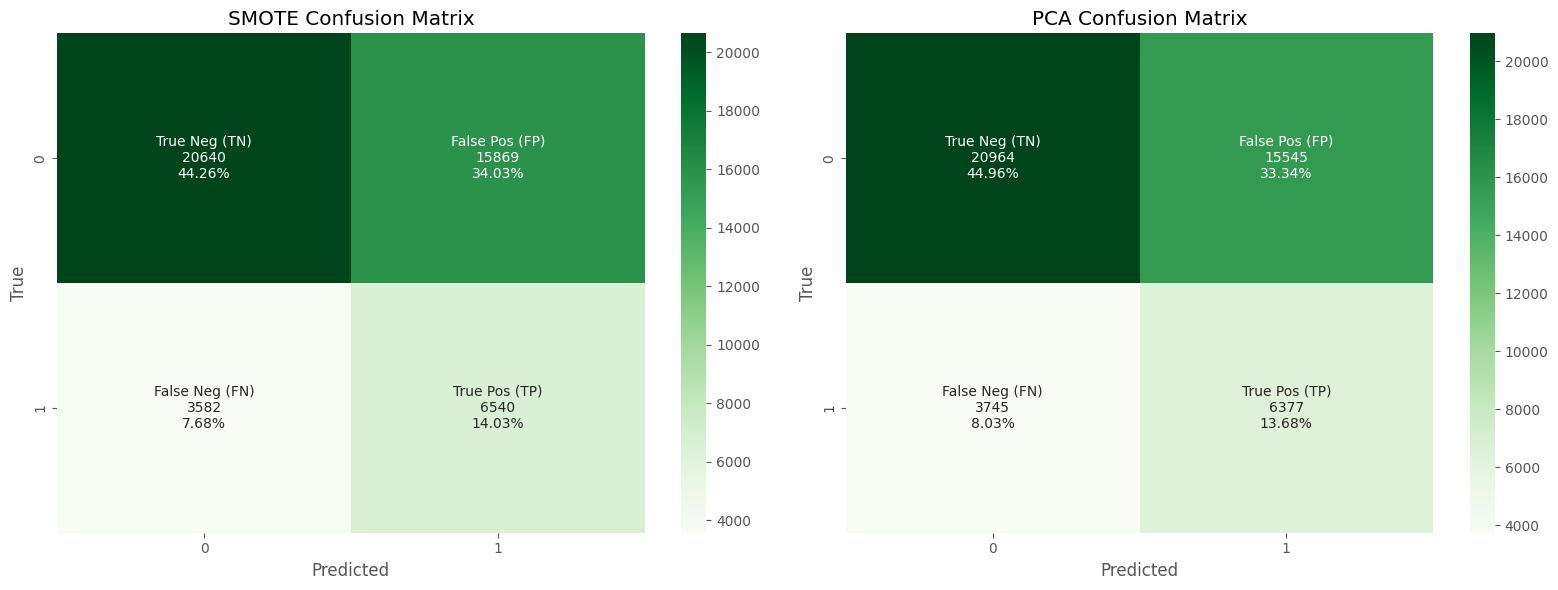

In [6]:
def plot_labeled_confusion_matrix(y_true, y_prob, title, ax, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg (TN)','False Pos (FP)','False Neg (FN)','True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_labeled_confusion_matrix(y_test, y_prob_smote, 'SMOTE Confusion Matrix', ax1)
plot_labeled_confusion_matrix(y_test, y_prob_pca, 'PCA Confusion Matrix', ax2)
plt.tight_layout()
plt.show()

> [!NOTE]
> **Final Evaluation Comparison**: We can now compare if adding synthetic data (SMOTE) or simplifying the space (PCA) yields better results than our previous XGBoost baseline.